In [1]:
library(tidyverse)
library(ggpubr)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [4]:
csq = read_tsv("output/freebayes_at9852_ath_filt-q100-ac10-dp100-200k-only1k1g-csq_allgenes_csqtab.tsv",
              col_names=c("chrom", "pos", "pos2", "alt", "qual", "af", "bcsq"), na=".")

Rows: 5495049 Columns: 7
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): chrom, alt, bcsq
dbl (4): pos, pos2, qual, af

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
glimpse(csq)

Rows: 5,495,049
Columns: 7
$ chrom <chr> "at9852_1_chr1", "at9852_1_chr1", "at9852_1_chr1", "at9852_1_chr…
$ pos   <dbl> 10217868, 10217903, 10217916, 10217925, 10217936, 10217942, 1021…
$ pos2  <dbl> 10217868, 10217903, 10217916, 10217925, 10217936, 10217942, 1021…
$ alt   <chr> "C", "G", "T", "T", "T", "T", "A", "A", "G", "G", "T", "A", "*",…
$ qual  <dbl> 3686.770, 25805.400, 3160.830, 1006.100, 444.778, 1538.860, 623.…
$ af    <dbl> 0.01575240, 0.02794700, 0.00848988, 0.00253807, 0.00180636, 0.00…
$ bcsq  <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, "3_prime_utr|at9852_G030…


In [6]:
csq2 = csq %>%
    filter(!is.na(bcsq), !grepl("^@", bcsq)) %>%
    mutate(bcsq=sub(",.*", "", bcsq)) %>%
    separate_wider_delim(bcsq, "|", names=c("csqtype", "gene_id", "transcript", "genetype", "strand", "aa", "cds"), too_few="debug", too_many="debug") %>%
    glimpse() %>%
    select(gene_id, chrom, pos, alt, qual, af, csqtype) %>%
    mutate(csqtype=sub("&.*", "", csqtype)) %>%
    filter(!grepl("^\\*", csqtype)) %>%
    group_by(gene_id) %>%
    mutate(genepos = (pos - min(pos)) / ( max(pos)-min(pos)))

Warning message:
“Debug mode activated: adding variables `bcsq_ok`, `bcsq_pieces`, and `bcsq_remainder`.”


Rows: 3,899,433
Columns: 17
$ chrom          <chr> "at9852_1_chr1", "at9852_1_chr1", "at9852_1_chr1", "at9…
$ pos            <dbl> 10217991, 10217994, 10218002, 10218003, 10218013, 10218…
$ pos2           <dbl> 10217991, 10217994, 10218002, 10218003, 10218013, 10218…
$ alt            <chr> "T", "A", "C", "C", "C", "C", "G", "A", "C", "C", "G", …
$ qual           <dbl> 5082.160, 8291.720, 3452.340, 2381.980, 25081.100, 2508…
$ af             <dbl> 0.00962936, 0.00653120, 0.00292291, 0.00565487, 0.01112…
$ csqtype        <chr> "3_prime_utr", "3_prime_utr", "3_prime_utr", "3_prime_u…
$ gene_id        <chr> "at9852_G030050", "at9852_G030050", "at9852_G030050", "…
$ transcript     <chr> "at9852_G030050_mRNA01", "at9852_G030050_mRNA01", "at98…
$ genetype       <chr> "protein_coding", "protein_coding", "protein_coding", "…
$ strand         <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ aa             <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ cds       

In [7]:
sumaf = csq2 %>%
    filter(af > 0.005) %>%
    mutate(severe=csqtype %in% c("frameshift", "stop_gained", "feature_elongation", "start_lost", "stop_gained", "stop_lost"))%>% 
    glimpse() %>%
    group_by(gene_id, severe) %>%
    summarise(sum_af=sum(af)) %>%
    glimpse()

Rows: 2,397,217
Columns: 9
Groups: gene_id [26,612]
$ gene_id <chr> "at9852_G030050", "at9852_G030050", "at9852_G030050", "at9852_…
$ chrom   <chr> "at9852_1_chr1", "at9852_1_chr1", "at9852_1_chr1", "at9852_1_c…
$ pos     <dbl> 10217991, 10217994, 10218003, 10218013, 10218017, 10218026, 10…
$ alt     <chr> "T", "A", "C", "C", "C", "G", "C", "G", "T", "G", "T", "T", "A…
$ qual    <dbl> 5082.160, 8291.720, 2381.980, 25081.100, 25081.100, 25081.100,…
$ af      <dbl> 0.00962936, 0.00653120, 0.00565487, 0.01112790, 0.04526590, 0.…
$ csqtype <chr> "3_prime_utr", "3_prime_utr", "3_prime_utr", "3_prime_utr", "3…
$ genepos <dbl> 0.000000000, 0.004065041, 0.016260163, 0.029810298, 0.03523035…
$ severe  <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE,…


`summarise()` has grouped output by 'gene_id'. You can override using the `.groups` argument.


Rows: 34,665
Columns: 3
Groups: gene_id [26,612]
$ gene_id <chr> "at9852_G000010", "at9852_G000020", "at9852_G000030", "at9852_…
$ severe  <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, TRUE, FALSE, …
$ sum_af  <dbl> 1.09566688, 5.64541573, 2.38047658, 6.32321413, 2.12263240, 4.…


In [9]:
genes = read_tsv("../paper_plots//orthogroup_stats//input//nlr_cleaned.tsv") %>%
    glimpse()

Rows: 3866 Columns: 13
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (10): accession, chrom, strand, id, nlr_tracker_type, nlr_tracker_domain...
dbl  (3): start, end, gene_length

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 3,866
Columns: 13
$ accession           <chr> "at6923", "at6923", "at6923", "at6923", "at6923", …
$ chrom               <chr> "at6923_1_chr3", "at6923_1_chr3", "at6923_1_chr3",…
$ start               <dbl> 24095005, 24098859, 24102069, 24105452, 24109306, …
$ end                 <dbl> 24096087, 24099909, 24102721, 24106534, 24110356, …
$ strand              <chr> "#ERROR!", "#ERROR!", "#ERROR!", "#ERROR!", "#ERRO…
$ id                  <chr> "at6923_G196830", "at6923_G196850", "at6923_G19686…
$ nlr_tracker_type    <chr> "RPW8", "RPW8", "RPW8", "RPW8", "RPW8", "RPW8", "R…
$ nlr_tracker_domains <chr> "(RPW8)", "(RPW8)", "(RPW8)", "(RPW8)", "(RPW8)", …
$ fine_og             <chr> "OG0000213-cluster-1", "OG0000213-cluster-1", "OG0…
$ broad_og            <chr> "OG0000213", "OG0000213", "OG0000213", "OG0000213"…
$ nh                  <chr> "chr3_nh13", "chr3_nh13", "chr3_nh13", "chr3_nh13"…
$ gene_status         <chr> "gene", "gene", "gene", "gene", "gene", "gene", "g…
$ gene_length   

In [10]:
pdat = sumaf %>%
    left_join(genes %>% select(gene_id=id, nlrtype=nlr_tracker_type), by="gene_id") %>%
    mutate(is_nlr=ifelse(is.na(nlrtype), "Non-NLR", "NLR"))

In [11]:
alltypes = csq2 %>%
    filter(af > 0.005) %>%
    group_by(gene_id, csqtype) %>%
    summarise(sum_af=sum(af), .groups="drop") %>%
    left_join(genes %>% select(gene_id=id, nlrtype=nlr_tracker_type), by="gene_id") %>%
    mutate(is_nlr=ifelse(is.na(nlrtype), "Non-NLR", "NLR")) %>%
    mutate(csqtype=fct_reorder(csqtype, sum_af, .fun=sum)) %>%
    glimpse()

Rows: 150,587
Columns: 5
$ gene_id <chr> "at9852_G000010", "at9852_G000010", "at9852_G000010", "at9852_…
$ csqtype <fct> 3_prime_utr, intron, missense, splice_donor, splice_region, sy…
$ sum_af  <dbl> 0.13662552, 0.77672726, 0.01837062, 0.09292330, 0.03854024, 0.…
$ nlrtype <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA…
$ is_nlr  <chr> "Non-NLR", "Non-NLR", "Non-NLR", "Non-NLR", "Non-NLR", "Non-NL…


Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2 3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”
Warning message:
“Removed 212 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 212 rows containing non-finite outside the scale range (`stat_boxplot()`).”


ERROR: Error in loadNamespace(x): there is no package called ‘svglite’


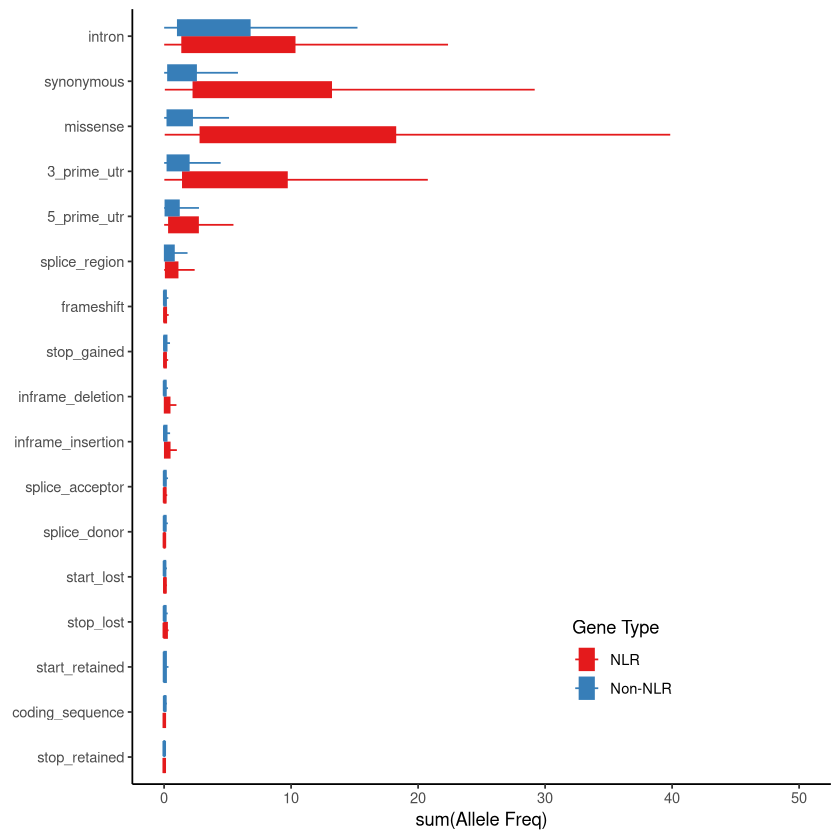

In [12]:
p = alltypes %>%
    ggplot(aes(y=csqtype, x=sum_af, colour=is_nlr, fill=is_nlr)) +
        geom_boxplot(outlier.shape = NA) +
        scale_fill_brewer(palette="Set1", name="Gene Type", aesthetics = c("fill", "colour")) +
        xlim(c(0, 50)) +
        labs(y=NULL, x="sum(Allele Freq)") +
        theme_classic() +
        theme(
            legend.position = c(.7, .16),
            axis.text.y=element_text(angle=0, hjust=1, vjust=0.5),
        )
print(p)
ggsave("output/all_types_sumaf_boxplot.png", width=3, height=4)
ggsave("output/all_types_sumaf_boxplot.svg", width=3, height=4)
saveRDS(p, "output/all_types_sumaf_boxplot.rds")

Warning message:
“Removed 781 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 781 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 781 rows containing non-finite outside the scale range (`stat_boxplot()`).”


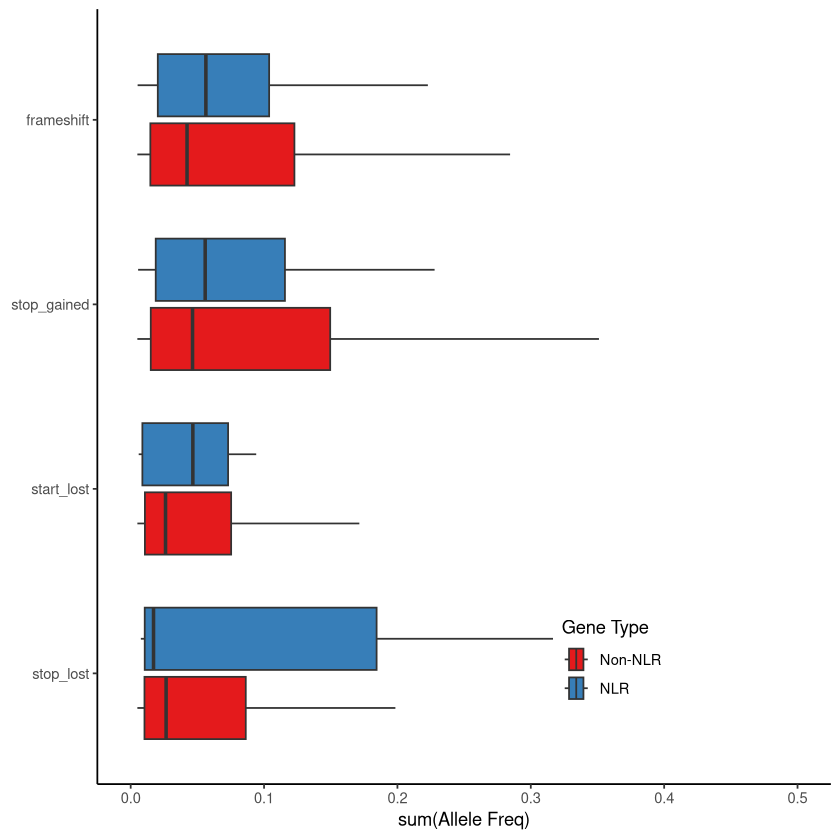

In [16]:
p = alltypes %>%
    filter(csqtype %in% c("frameshift", "stop_gained", "feature_elongation", "start_lost", "stop_gained", "stop_lost"))%>% 
    mutate(
        is_nlr=factor(is_nlr, levels=c("Non-NLR", "NLR")),
    ) %>%
    ggplot(aes(y=csqtype, x=sum_af, fill=is_nlr)) +
        geom_boxplot(outlier.shape = NA) +
        scale_fill_brewer(palette="Set1", name="Gene Type", aesthetics = c("fill", "colour")) +
        xlim(c(0, .5)) +
        labs(y=NULL, x="sum(Allele Freq)") +
        theme_classic() +
        theme(
            legend.position = c(.7, .16),
            axis.text.y=element_text(angle=0, hjust=1, vjust=0.5),
        )
print(p)
ggsave("output/severe_types_sumaf_boxplot.png", width=3, height=4)
ggsave("output/severe_types_sumaf_boxplot.svg", width=3, height=4)
saveRDS(p, "output/severe_types_sumaf_boxplot.rds")

Warning message:
“Removed 763 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 763 rows containing non-finite outside the scale range (`stat_signif()`).”
Warning message:
“Removed 763 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 763 rows containing non-finite outside the scale range (`stat_signif()`).”
Warning message:
“Removed 763 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 763 rows containing non-finite outside the scale range (`stat_signif()`).”


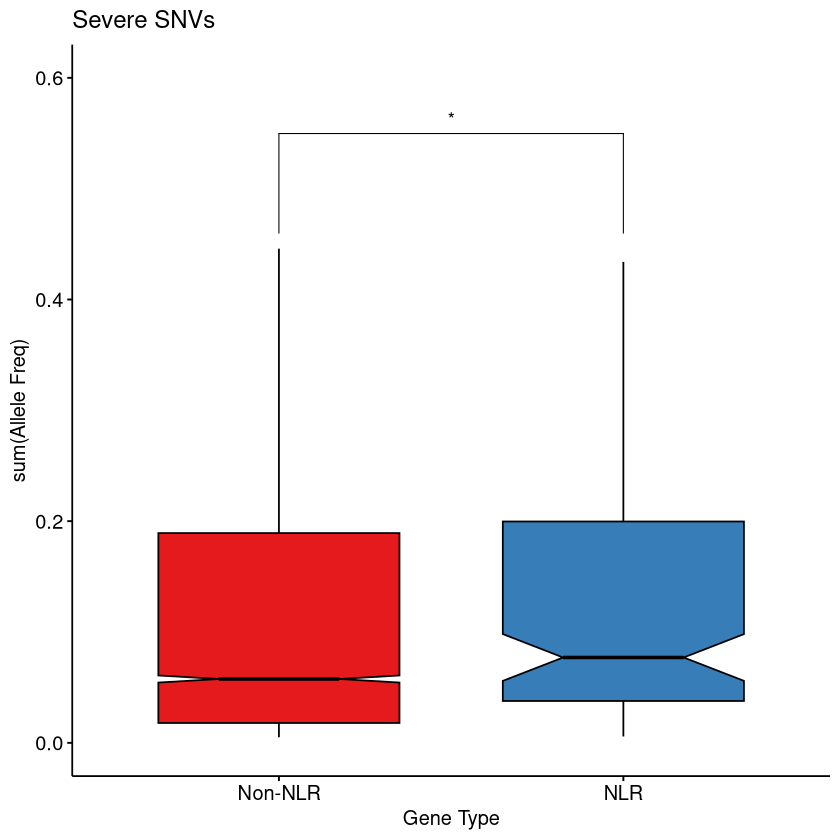

In [29]:
p = pdat %>%
    filter(severe) %>%
    ggboxplot(y="sum_af", x="is_nlr", fill="is_nlr", outlier.shape = NA, notch=T) +
        stat_compare_means(comparisons=list(c("Non-NLR", "NLR")), label = "p.signif", label.y=0.40) +
        scale_fill_brewer(palette="Set1", name="Gene Type") +
        scale_y_continuous(limits = c(0, 0.6)) +
        labs(x="Gene Type", y="sum(Allele Freq)", title="Severe SNVs") +
        theme(legend.position = "none")
print(p)
saveRDS(p, "output/sumaf-normalvsnlr-onlysevere.rds")
ggsave("output/sumaf-normalvsnlr-onlysevere.png", width=3, height=3, dpi=600)
ggsave("output/sumaf-normalvsnlr-onlysevere.svg", width=3, height=3)

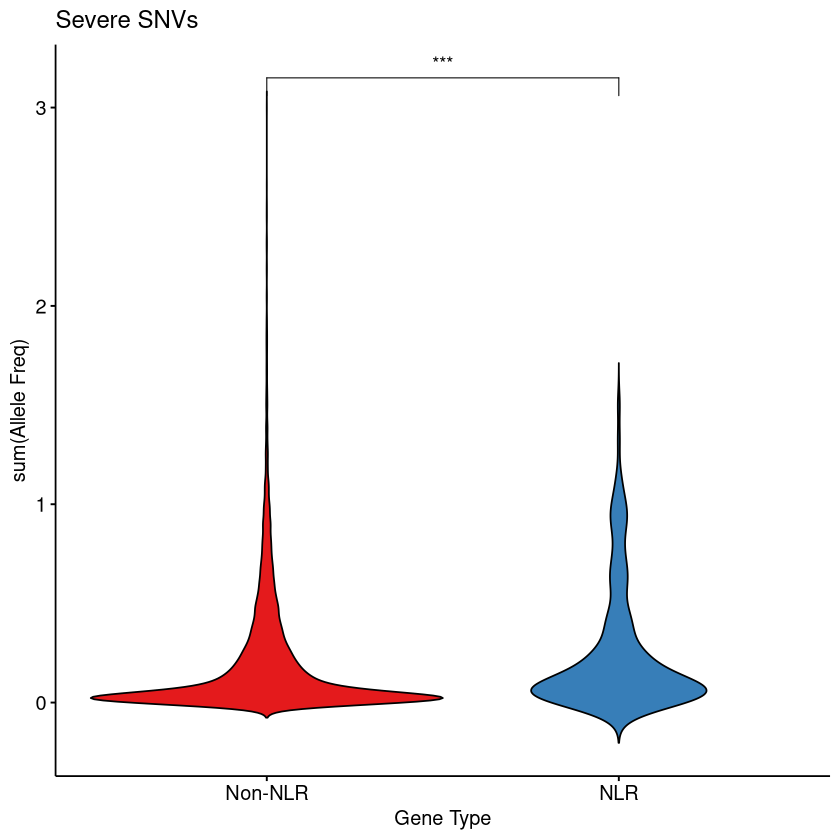

In [23]:
p = pdat %>%
    filter(severe) %>%
    ggviolin(y="sum_af", x="is_nlr", fill="is_nlr") +
        stat_compare_means(comparisons=list(c("Non-NLR", "NLR")), label = "p.signif") +
        scale_fill_brewer(palette="Set1", name="Gene Type") +
        #scale_y_continuous(limits = c(0, 3.2)) +
        labs(x="Gene Type", y="sum(Allele Freq)", title="Severe SNVs") +
        theme(legend.position = "none")
print(p)
saveRDS(p, "output/sumaf-normalvsnlr-onlysevere.rds")
ggsave("output/sumaf-normalvsnlr-onlysevere.png", width=2, height=3, dpi=600)
ggsave("output/sumaf-normalvsnlr-onlysevere.svg", width=2, height=3)

Warning message:
“Removed 42 rows containing missing values or values outside the scale range (`geom_violin()`).”
Warning message:
“Removed 42 rows containing missing values or values outside the scale range (`geom_violin()`).”
Warning message:
“Removed 42 rows containing missing values or values outside the scale range (`geom_violin()`).”


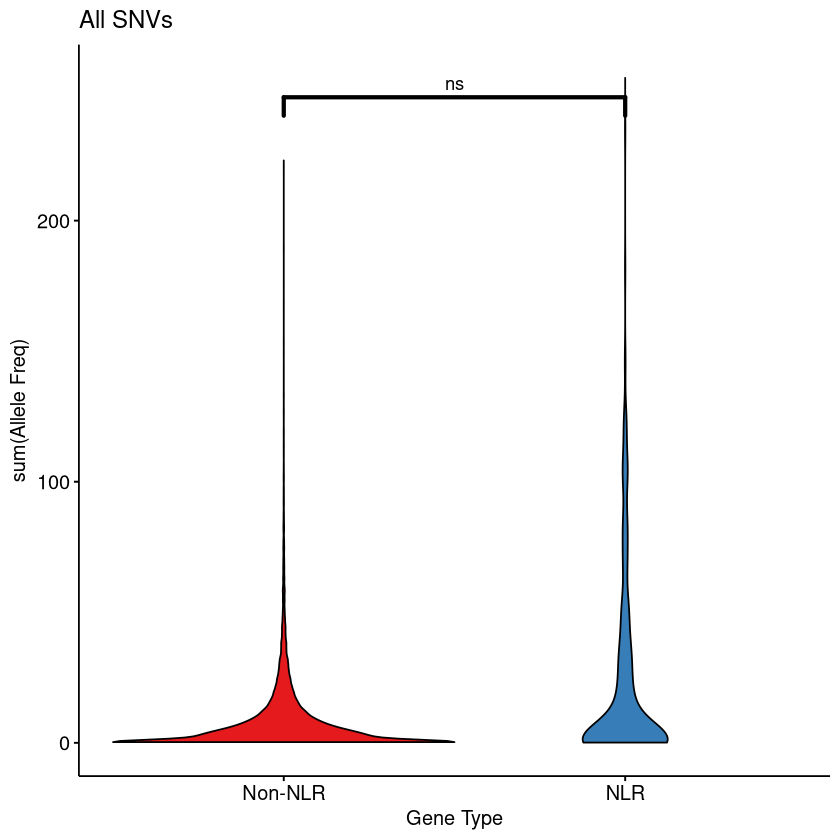

In [19]:
p = pdat %>%
    ggviolin(y="sum_af", x="is_nlr", fill="is_nlr") +
        stat_compare_means(comparisons=list(c("Non-NLR", "NLR")), label = "p.signif", label.y.npc = 0.9, bracket.size = 1.2) +
        scale_fill_brewer(palette="Set1", name="Gene Type") +
        scale_y_continuous(limits = c(0, NA)) +
        labs(x="Gene Type", y="sum(Allele Freq)", title="All SNVs") +
        theme(legend.position = "none")
print(p)
saveRDS(p, "output/sumaf-normalvsnlr-allvariants.rds")
ggsave("output/sumaf-normalvsnlr-allvariants.png", width=2, height=3, dpi=600)
ggsave("output/sumaf-normalvsnlr-allvariants.svg", width=2, height=3)